In [128]:
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
from copy import copy

# CMPSC 450 Mini-Project

#### Authors: Brian Nguyen, Daniel Marzec

The purpose of our project is to implement a computer vision image pre-processing technique called adaptive histogram equalization, and parallelize it using MPI and CUDA. We would then compare performance of the implementation between serial, MPI, and CUDA runs with different graphics cards.

### Algorithm Implementation

In [197]:
def rgb2gray(rgb):
    """ Convert an RGB image to grayscale. """
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


def hist_eq(img, intensity_val):
    """ Normal image histogram equalization for improved contrast. """
    
    n = len(img[0])
    m = len(img[:,0])
    
    final_img = copy(img)
    pixel_freq = {}
    pdf = {}
    cdf = {}
    pixel_count = n * m    
    
    # for each pixel in the image update pixel frequency
    for i in range(n):
        for j in range(m):
            pixel_val = img[i, j]
            if pixel_val in pixel_freq:
                pixel_freq[pixel_val] += 1
            else:
                pixel_freq[pixel_val] = 1
    
    # for each pixel value, calculate its probability
    for pixel_val, freq in pixel_freq.items():
        pdf[pixel_val] = freq / pixel_count
    
    # order the pdf in order to calculate cdf
    pdf = OrderedDict(sorted(pdf.items(), key=lambda t: t[0]))
    
    # for each pixel value, update cdf
    prev = 0
    for pixel_val, prob in pdf.items():
        cdf[pixel_val] = prev + pdf[pixel_val]
        prev = cdf[pixel_val]
        cdf[pixel_val] = round(cdf[pixel_val] * intensity_val)
    
    # update all pixels
    for i in range(n):
        for j in range(m):
            final_img[i, j] = cdf[img[i, j]]
    
    return final_img


def window_hist(img, coords, slider_len):
    """ Calculate new pixel value for the center pixel
    in an image window for adaptive histogram equalization. """
    
    pixel_freq = {}
    pdf = {}
    cdf = {}
    pixel_count = slider_len ** 2
    center_pixel_val = img[coords[0], coords[1]]
    
    # for each pixel in the window update pixel frequency
    for i in range(slider_len):
        for j in range(slider_len):
            pixel_val = img[i, j]
            if pixel_val in pixel_freq:
                pixel_freq[pixel_val] += 1
            else:
                pixel_freq[pixel_val] = 1
                
    # for each pixel value, calculate its probability
    for pixel_val, freq in pixel_freq.items():
        pdf[pixel_val] = freq / pixel_count
    
    # order the pdf in order to calculate cdf
    pdf = OrderedDict(sorted(pdf.items(), key=lambda t: t[0]))
    
    # for each pixel value, update cdf
    prev = 0
    for pixel_val, prob in pdf.items():
        cdf[pixel_val] = prev + pdf[pixel_val]
        prev = cdf[pixel_val]
        cdf[pixel_val] = round(cdf[pixel_val] * 250)
        
        # once the cdf reaches the target pixel, no need to continue
        if pixel_val == center_pixel_val:
            break
        
    return cdf[center_pixel_val]


def adaptive_hist_eq(img, slider_len):
    """ Apply sliding window adaptive histogram equalization to an image
    for improved local contrast. """
    
    # make a copy of original to replace pixels
    final_img = copy(img)
    n = len(img[0])
    m = len(img[:,0])

    gap = int(slider_len // 2)  # left and right shifts
    coords = (slider_len - gap - 1, slider_len - gap - 1)  # coordinates for center pixel in window
    
    # for each pixel in the center of the image, apply adaptive histogram equalization
    for i in range(gap, n - gap):
        for j in range(gap, m - gap):
            final_img[i, j] = window_hist(img[i-gap:i+gap, j-gap:j+gap], coords, slider_len-1)
            
    return final_img

### Test on image

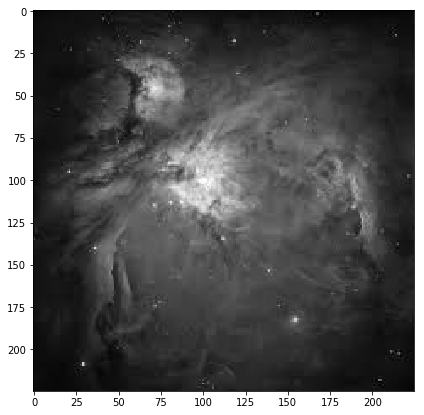

In [193]:
# original image
img = plt.imread("test_image3.jpeg")
gray = rgb2gray(img)
clean_image = np.matrix.round(gray)
plt.figure(figsize=(13,7))
plt.imshow(clean_image, cmap=plt.get_cmap('gray'))
plt.show()

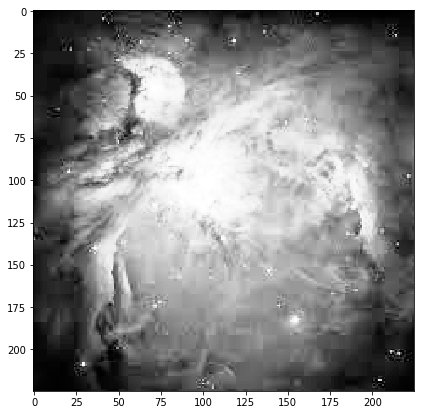

In [201]:
# normal histogram equalization
plt.figure(figsize=(13,7))
plt.imshow(hist_eq(clean_image), cmap=plt.get_cmap('gray'))
plt.show()

In [198]:
output_image = adaptive_hist_eq(clean_image, 55)

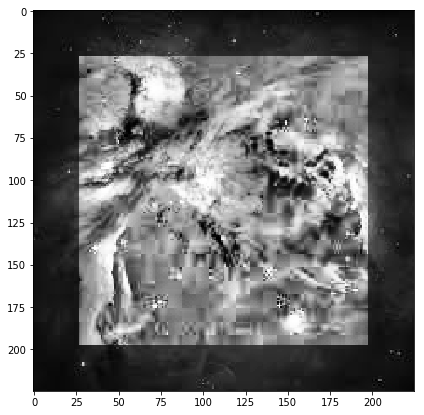

In [199]:
# adaptive histogram equalization
plt.figure(figsize=(13,7))
plt.imshow(output_image, cmap=plt.get_cmap('gray'))
plt.show()